<a href="https://colab.research.google.com/github/mffg1993/SLMPy/blob/main/Tutorials/Basic_calculations_on_phase_only_Holography.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Calculation of a phase-only hologram

*Based on "Exact solution to simultaneous intensity
and phase encryption
with a single phase-only hologram"*


Let us consider that the incident field is a  plane wave. The desired output beam can be defined as


\begin{equation}
E(\mathbf{r},z_0)= A(\mathbf{r},z_0)\, \exp\left[ i \Phi(\mathbf{r},z_0)\right], \tag{1}
\end{equation}


where $\mathbf{r}$ is the transverse coordinate, $A(\mathbf{r},z_0)= |E(\mathbf{r},z_0)|$ and $\Phi(\mathbf{r},z_0)=\text{Arg}\left[ \Phi(\mathbf{r},z_0)\right]$ are the amplitude and phase of the optical field. The imprinted phase profie of the hologram is given by

\begin{equation}
\Psi(m,n)= \mathcal{M}(m,n) \text{Mod}\left[ \mathcal{F}(m,n) + 2 \pi m / \Lambda, 2\pi \right], \tag{2}
\end{equation}

where $m$ and $n$ are the pixel coordinate, $\Lambda$ is the period of the blazed grating pattern, $\mathcal{M}$ is a normalized bounded positive function of amplitude ($0\leq\mathcal{M}\leq 1$) and  $\mathcal{F}$ is an analytical function of the amplitude and phase profiles of the desired field. Just after passing the hologram, the input plane wave acquires the imprinted phase profile and is given by

\begin{equation}
T(m,n)=\exp\left( i \mathcal{M}(m,n) \text{Mod}\left[ \mathcal{F}(m,n) + 2 \pi m / \Lambda, 2\pi \right] \right) \tag{3}
\end{equation}

A calculation based on a Taylor-Fourier expansion shows that the action of this particular optical phase (after spatial filtering all the diffraction orders except the first one) can be expressed as,

\begin{equation}
T_1(m,n)= -\text{sinc}(\pi \mathcal{M} - \pi) e^{i(\mathcal{F}+\pi\mathcal{M})} \tag{4}
\end{equation}

By comparison between Eq.(1) and Eq.(4), we get

\begin{align}
\mathcal{M}&=1+\frac{1}{\pi} \text{sinc}^{-1}(A) \tag{5.a}\\
\mathcal{F}&= \Phi-\pi \mathcal{M} \tag{5.b}
\end{align}

where $\text{sinc}^{-1}(\cdot)$ stands for the inverse fucntion of the sinc function in the domain $[-\pi,0]$

# Python implementation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math

##############################################################################################
# Basic utilities
##############################################################################################

# Cartesian to Polar coordinates
def cart2pol(x, y):
  rho = np.sqrt(x**2 + y**2)
  phi = np.arctan2(y, x)
  return(rho, phi)


# Chopping function as in Mathematica
def Chop(A):
    return(np.real(A)*(np.abs(np.real(A)>1e-8))+np.imag(A)*(np.abs(np.imag(A)>1e-8)))


##############################################################################################
# Hologram
##############################################################################################


def Gaussian(X,Y,theta):
    p=1
    kx=0*k*np.cos(theta)
    ky=k*np.sin(theta)
    a=p*np.exp(1j*(kx*X+ky*Y))+np.exp(0*1j*k*X)
    return(a)



## Generation of a Laguerre-Gaussian Hologram
def HoloG(theta,z=(0,5),Z=(1,0,0,0),LA=0.09,maxx=1,SLM_Pix=(1024,780),position=(0,0)):
    rate=SLM_Pix[1]/SLM_Pix[0] # Assuming squared pixels
    maxy=rate*maxx; #Scaling of the Y axis

    # Space definition + displacements
    X=np.linspace(-maxx,maxx,SLM_Pix[0])+position[0];
    Y=-np.linspace(-maxy,maxy,SLM_Pix[1])+position[1];

    # Relevant stuff
    dx=np.abs(X[1]-X[2]);
    dy=np.abs(Y[1]-Y[2]);
    xx,yy=np.meshgrid(X,Y);
    r, phi= cart2pol(xx,yy)

    # Zernike Polynomial mask - Zorro no te lo lleves!
    ZPM=Zernike(r/Z[0],phi,Z[2],Z[3])

    # HG beam including the Zernike Polynomial stuff
    A=Gaussian(xx,yy,theta)*np.exp(1j*2*np.pi*Z[1]*ZPM)

    # Propagating the shit out of me :)
    if z[0]>0:
        # Propagation space
        ZZ=np.linspace(0,z[0],z[1])

        # Propagation steps
        dz=np.abs(ZZ[0]-ZZ[1])

        # Saving the field at every plane
        F=[A]

        for ii in range(0,z[1]):
            A=propTF(A,2*maxx,1,dz) # Field at plane z->z_0
            F.append(A)

    # Generation of the Hologram
    return(Hologram(A,dx,dy,LA))

# Generation of hologram given a field A - Implementation of Equation(2) when Equation (5) are substituted
def Hologram(A,hx,hy,LA):
    # A       -> Complex amplitude of the beam
    # hx, hy  -> Spatial steps in x and y direction
    # LA      -> Period of the blazed grating pattern

    # Normalization of the desired beam
    nn=np.sum(np.abs(A)**2)*hx*hy
    NU=A/np.sqrt(nn)

    # Amplitude and phase profiles of the desired beam
    Amp=np.abs(NU)
    PHI=np.angle(NU)

    # Blazed grating pattern
    mm=Amp.shape
    x1,y1=np.meshgrid(hx*np.arange(1,mm[1]+1),hy*np.arange(1,mm[0]+1))

    # Inverse sinc fucntion
    ss=np.linspace(-np.pi,0,2000)
    sincc=np.sin(ss)/ss
    sincc[np.isnan(sincc)]=1

    # Amplitude masking
    M=1+np.interp(Amp,sincc,ss)/np.pi
    M[np.isnan(M)]=0


    # Phase hologram
    F=np.mod(PHI-np.pi*M+x1/LA,2*np.pi)

    # It returns the full hologram
    return M*F


# Generation of a Laguerre-Gaussian Hologram - a particular case that simulates a hologram in a SLM

def HoloLG(l,p,w0,z=(0,5),Z=(1,0,0,0),LA=0.09,maxx=1,SLM_Pix=(1024,780),position=(0,0)):
    # l        -> Azimuthal index for the LG mode
    # p        -> Radial index for the LG mode
    # w0       -> Waist parameter of the Gaussian envelope
    # z        -> Tuple that indicates the parameters of the Fresnel propagation. It takes (0,5) as default if none is given.
    # Z        -> Tuple that indicates the parameters of the phase mask that contains the Zernike Polynomials. It takes (aperture=1,strength=0,m=0,n=0) as default if none is given.
    # LA       -> Period of the blazed grating pattern
    # maxx     -> Half-lenght of the SLM in the horizontal direction (BETA)
    # SLM_Pix  -> Tuple that considers the pixel size of the SLM. It takes (1024,780) as default if none is given
    # position -> Tuple that indicates the new beam's centre. It is considered as (0,0) if none is given

    rate=SLM_Pix[1]/SLM_Pix[0] # Assuming squared pixels
    maxy=rate*maxx; #Scaling of the Y axis

    # Space definition + displacements
    X=np.linspace(-maxx,maxx,SLM_Pix[0])+position[0];
    Y=-np.linspace(-maxy,maxy,SLM_Pix[1])+position[1];

    # Relevant stuff
    dx=np.abs(X[1]-X[2]);
    dy=np.abs(Y[1]-Y[2]);
    xx,yy=np.meshgrid(X,Y);
    r, phi= cart2pol(xx,yy)

    # Zernike Polynomial mask - Zorro no te lo lleves!
    ZPM=Zernike(r/Z[0],phi,Z[2],Z[3])

    # LG beam including the Zernike Polynomial stuff
    A=LG(r,phi,l,p,w0)*np.exp(1j*2*np.pi*Z[1]*ZPM)

    # Propagating the shit out of me :)
    if z[0]>0:
        # Propagation space
        ZZ=np.linspace(0,z[0],z[1])

        # Propagation steps
        dz=np.abs(ZZ[0]-ZZ[1])

        # Saving the field at every plane
        F=[A]

        for ii in range(0,nz):
            A=propTF(A,2*maxx,1,dz) # Field at plane z->z_0
            F.append(A)

    # Generation of the Hologram
    return([np.abs(A)**2,np.angle(A),Hologram(A,dx,dy,LA)])


##############################################################################################
# Numerical implementation of the Special functions
##############################################################################################

# Numerical Implementation of the Laguerre Polynomials based on the recurssion formula
def NlaguerreL(n,a,X):
  LL=0
  for m in range(n+1):
    LL=LL+((-1)**m)*(math.factorial(n+a))/(math.factorial(n-m)*math.factorial(a+m)*math.factorial(m))*(X**m);
  return(LL)

# Laguerre-Gaussian Beam where ell and p are the azimuthal and radial indexes, respectively
def LG(RHO,PHI,ell,p,w0):
    C=np.sqrt((2*math.factorial(p))/(np.pi*math.factorial(p+np.abs(ell))))*(1/w0)
    return(C*np.exp(-(RHO/w0)**2)*((np.sqrt(2)*RHO/w0)**np.abs(ell))*np.exp(1j*ell*PHI)*NlaguerreL(p,np.abs(ell),2*(RHO/w0)**2))


#Numerical definition of the Hermite Polynomials based on the recurssion formula
def NHermite(n,X):
    Hn1=np.ones(X.shape);
    H=2*X;
    if n<0:
        print('The index must be 0 or positive')
    elif n==0:
        H=Hn1;
    elif n==1:
        H=H;
    else:
        for nn in range(2,n+1):
            Hn=2*X*H-2*(nn-1)*Hn1;
            Hn1=H;
            H=Hn;
    return(H)

# Hermite Gaussian beam where m and n are the orders in the x and y direction, respectively
def HG(X,Y,m,n,w0):
    h=np.abs(X[0,0]-X[0,1])
    a=NHermite(m,np.sqrt(2)*X/w0)*NHermite(n,np.sqrt(2)*Y/w0)*np.exp(-(X**2+Y**2)/w0**2)
    N=np.sum(h*h*np.abs(a)**2)
    a=a/np.sqrt(N)
    return(a)

##############################################################################################
# Zernike Polynomials
##############################################################################################

# Coeffcients and powers or the radial Polynomials
def RR(m,n):
  nm=n-m
  coeff=[]
  pow=[]
  if (n-m)%2==0:
    for kk in range(0,int((n-m)/2+1)):
      aa=((-1)**kk*math.factorial(n-kk))/(math.factorial(kk)*math.factorial((n+m)/2-kk)*math.factorial((n-m)/2-kk))
      bb=n-2*kk
      coeff.append(aa)
      pow.append(bb)
  else:
    coeff.append(0)
    pow.append(0)
  return([coeff,pow])

# Construction of the polynomial
def Zernike(RHO,PHI,m,n):
  ZR=np.zeros(RHO.shape);
  rn=RR(np.abs(m),n)

  for ii in range(len(rn[0])):
    ZR=ZR+rn[0][ii]*RHO**rn[1][ii]

  if m>=0:
    Z=ZR*np.cos(np.abs(m)*PHI)
  else:
    Z=ZR*np.sin(np.abs(m)*PHI)
  M=(RHO<=1)
  P=Z*M
  P=(P-np.min(P))/np.max(P-np.min(P))
  return(P)

##############################################################################################
# Propagation operators
##############################################################################################

# Fresnel propagation using the Transfer function approach
# Based on Computational Fourier Optics by Voelz
# Generalization to non-square windows

def propTF(u1,Lx,Ly,la,z):
    # u1       -> Complex Amplitude of the beam at the source plane. It is a square array
    # Lx       -> Sidelength of the simulation window of the source plane in the X direction
    # Ly       -> Sidelength of the simulation window of the source plane in the X direction
    # lambda   -> Wavelength
    # z        -> Propagation distance
    # u2       -> Complex Amplitude of the beam at the observation plane

    # Dimensions of the array of the beam
    Yd,Xd=u1.shape

    # Sampling inteval size
    dx=Lx/Xd
    dy=Ly/Yd

    # Frequency coordinates sampling
    fx=np.arange(-1/(2*dx),1/(2*dx),1/Lx)
    fy=np.arange(-1/(2*dy),1/(2*dy),1/Ly)

    # Momentum/Reciprocal space
    Fx, Fy = np.meshgrid(fx, fy)

    # Transfer function
    H=np.exp(-1j*np.pi*0.25*la*z*(Fx**2+Fy**2))

    # Convolution between transfer function and the Fourier transform of the input beam
    U2=H*np.fft.fftshift(np.fft.fft2(u1))

    # Fourier transform of the convolution to the observation plane
    u2=np.fft.ifft2(np.fft.ifftshift(U2))
    return u2


# Fraunhofer propagation
# Assuming uniform sampling and presents reflections on the boundaries

def propFF(u1,L1,la,z):
    # u1 - Complex Amplitude of the beam at the source plane
    # L1 - Sidelength of the simulation window of the source plane
    # la - Wavelength
    # z  - Propagation distance
    # u2 - Complex Amplitude of the beam at the observation plane
    # L2 - Sidelength of the simulation window of the observation plane
    # X2 - X coordinates on the observation plane
    # Y2 - Y coordinates on the observation plane

    # Dimensions of the array of the beam
    M,nn=u1.shape

    # Sampling inteval size
    dx1=L1/M

    # Wavenumber
    k=2*np.pi/la

    # Sidelength of the simulation window of the observation plane
    L2=la*z/dx1

    # Sampling inteval size of the observation plane
    dx2=la*z/L1

    # Observation plane coordinates sampling
    x2=np.arange(-L2/2,L2/2,dx2)

    # Observation plane space
    X2,Y2=np.meshgrid(x2,x2);

    # Phase propagation
    c=1/(1j*la*z)*np.exp(1j*k/(2*z)*(X2**2+Y2**2))

    # Complex amplitude at the observation plane
    u2=np.fft.fftshift(np.fft.fft2(np.fft.fftshift(u1)))*dx1**2

    return [u2,L2,X2,Y2]

##############################################################################################
# Toolbox for the simulation
##############################################################################################

def Iris_filtering(r,pos,maxx,N):
    # Space definition
    X=np.linspace(-maxx,maxx,N);
    Y=-np.linspace(-maxx,maxx,N);
    xx,yy=np.meshgrid(X,Y);
    return(np.sqrt((xx-pos[0])**2+(yy-pos[1])**2)<r)

# Laguerre Gaussian Beam in a square grid

<ipython-input-25-523ece7b74e2>:45: RuntimeWarning: invalid value encountered in divide
  sincc=np.sin(ss)/ss


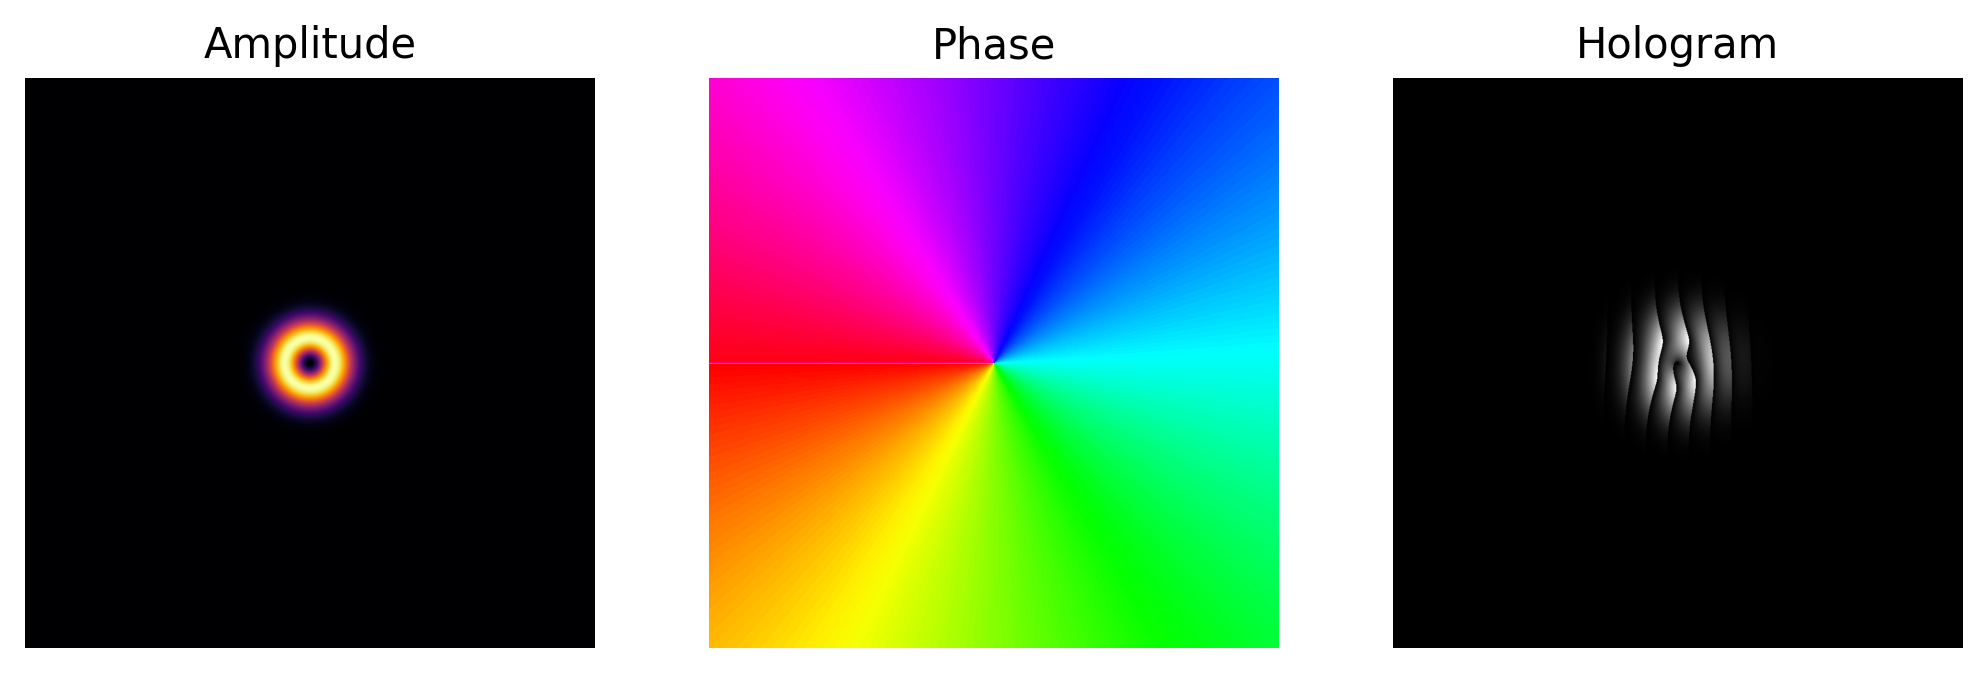

In [ ]:
# Beam profile

k=2*np.pi  # [m^-1] wavenumber         # [mm] beam waist
maxx=4       # [units of w0] Half length of the numerical window
N=1024        # [Number of points per dimension]
                # For fast results, consider using an square matrix and N to be a power of 2
# Space definition
X=np.linspace(-maxx,maxx,N);
Y=-np.linspace(-maxx,maxx,N);

h=np.abs(X[1]-X[2]);
xx,yy=np.meshgrid(X,Y);
r, phi= cart2pol(xx,yy)

A=LG(r,phi,1,0,0.5)
LA = 0.05

# Hologram calculation
Hol1=Hologram(A,h,h,LA)

plt.figure(figsize=(10,10),dpi=250)
plt.subplot(131)
plt.imshow(np.abs(A)**2,cmap="inferno")
plt.title('Amplitude')
plt.axis('off')

plt.subplot(132)
plt.imshow(np.angle(A),cmap='hsv')
plt.title('Phase')
plt.axis('off')

plt.subplot(133)
plt.imshow(Hol1,cmap='gray')
plt.title('Hologram')
plt.axis('off')
plt.show()

# Simulation of the Hologram use

In order to recover the information of this hologram, we have to go to the Far Field (focus of a lens). There, we will have multiple orders of diffraction:

- The central one is the zeroth order and corresponds to the reference wave used for the hologram.

- The non-centered ones contain the information of our tailored field.

Numerically, the Far Field can be obtained by considering the Franhofer propagator:

<ipython-input-25-523ece7b74e2>:45: RuntimeWarning: invalid value encountered in divide
  sincc=np.sin(ss)/ss


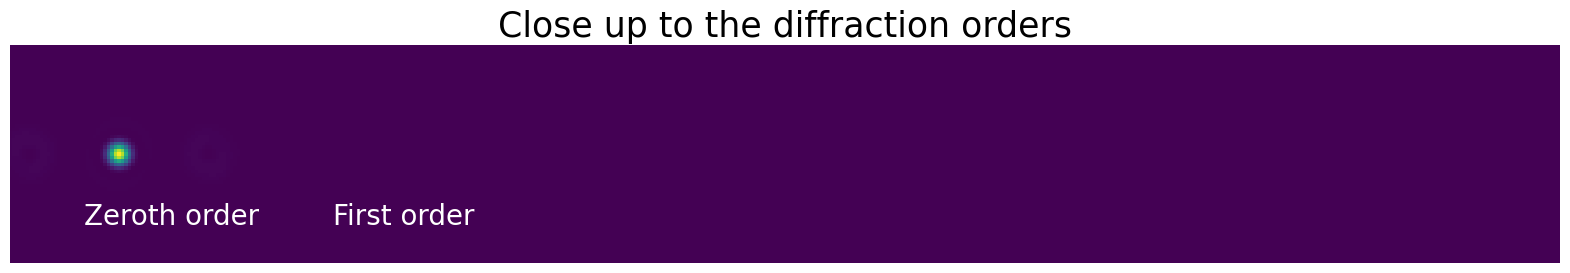

In [ ]:
# Beam profile

k=2*np.pi  # [m^-1] wavenumber         # [mm] beam waist
maxx=4       # [units of w0] Half length of the numerical window
N=1024        # [Number of points per dimension]
                # For fast results, consider using an square matrix and N to be a power of 2
# Space definition
X=np.linspace(-maxx,maxx,N);
Y=-np.linspace(-maxx,maxx,N);

h=np.abs(X[1]-X[2]);
xx,yy=np.meshgrid(X,Y);
r, phi= cart2pol(xx,yy)

A=LG(r,phi,1,0,0.5)
LA = 0.05

# Hologram calculation
Hol1=Hologram(A,h,h,LA)


# Going to the focal plane of a lens
KK=propFF(Hol1,2*maxx,1,2)

plt.figure(figsize=(20,20),dpi=100)
plt.imshow(np.abs(KK[0])**2)
plt.title('Close up to the diffraction orders',fontsize=25)
plt.text(np.round(N/2-0.01*N),np.round(N/2-0.02*N),'Zeroth order',color='w',fontsize=20)
plt.text(np.round(N/2+0.06*N),np.round(N/2-0.02*N),'First order',color='w',fontsize=20)
plt.xlim([np.round(N/2-0.03*N),np.round(N/2+0.4*N)])
plt.ylim([np.round(N/2-0.03*N),np.round(N/2+0.03*N)])
#plt.ylim([230,280])
plt.axis('off')
plt.show()

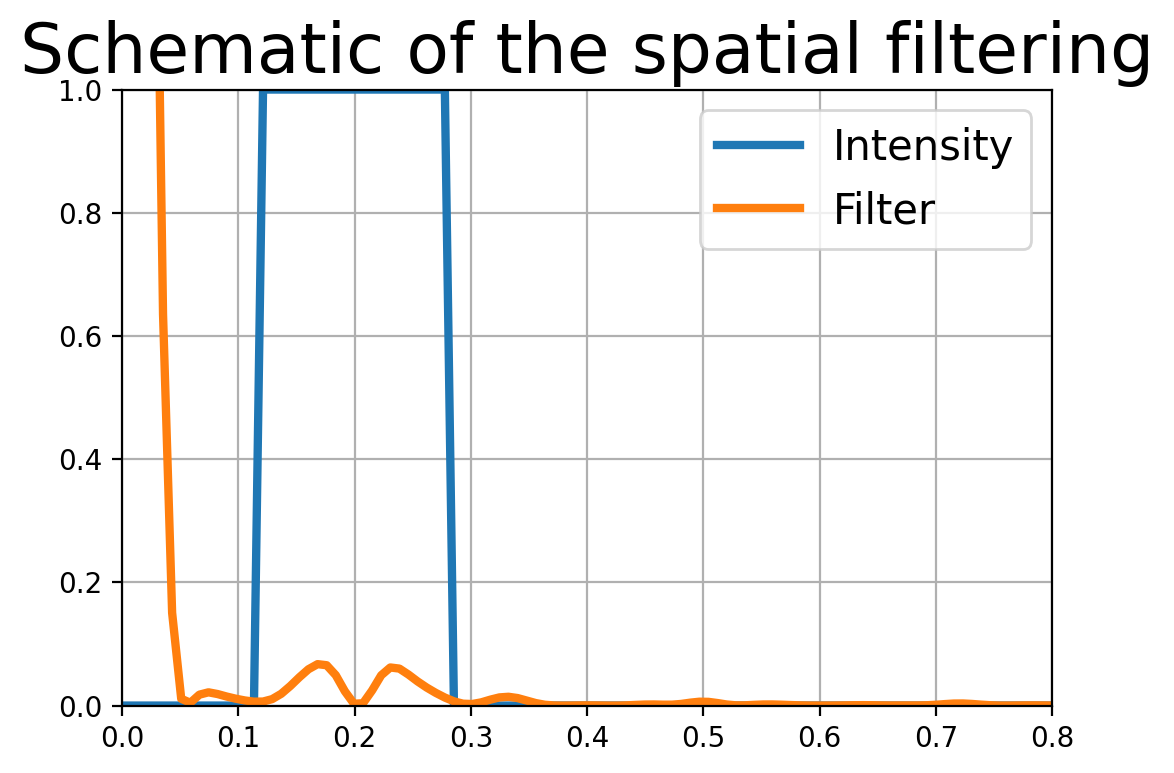

In [ ]:
ff=Iris_filtering(0.2,(0.5,0),10,N)

X=np.linspace(-maxx,maxx,N);
amm=np.abs(KK[0])**2

plt.figure(figsize=(6,4),dpi=200)
plt.title('Schematic of the spatial filtering',fontsize=25)
plt.plot(X,ff[int(np.round(N/2)),:],linewidth=3)
plt.plot(X,5*amm[int(np.round(N/2)),:]/np.max(amm[int(np.round(N/2)),:]),linewidth=3)

plt.xlim([0,0.8])
plt.ylim([0,1])
#plt.xticks(fontsize=20)
plt.grid('on')
#plt.yticks(fontsize=20)
#plt.text(252,0.2,'Zeroth order',color='k',fontsize=20)
#plt.text(287,0.2,'First order',color='k',fontsize=20)
plt.legend(['Intensity','Filter'],prop={'size': 15})
plt.show()



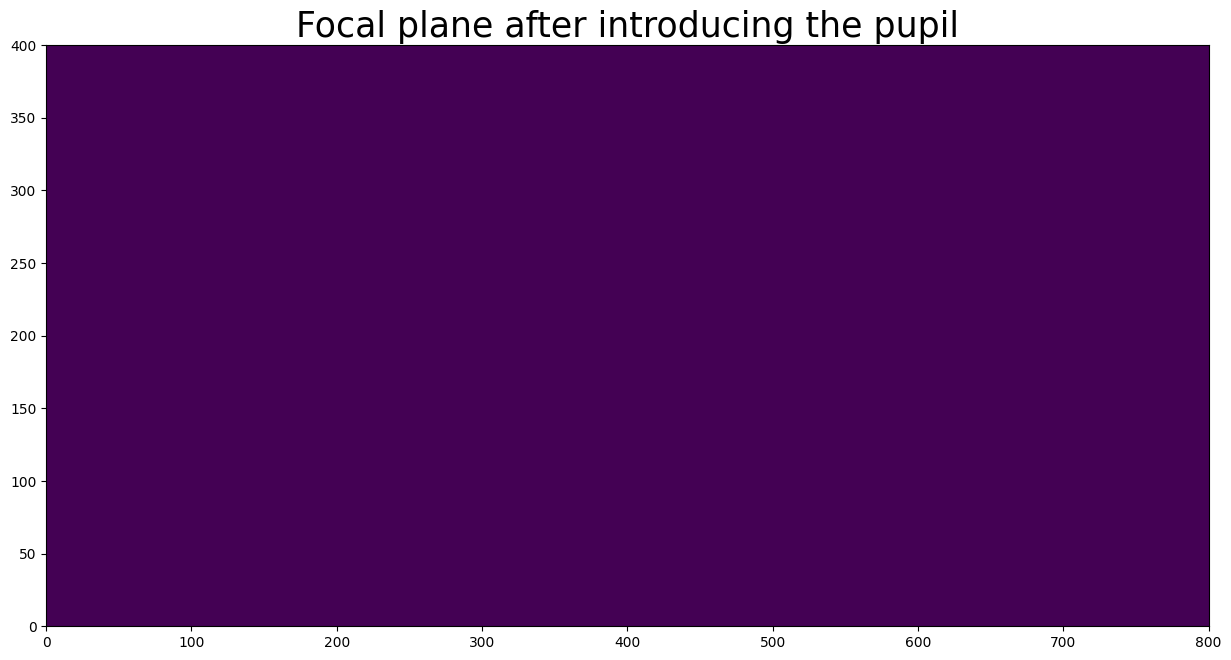

In [ ]:
U1=1000*ff*KK[0]
plt.figure(figsize=(15,15),dpi=100)
plt.imshow(1000*np.abs(U1)**2)
plt.title('Focal plane after introducing the pupil',fontsize=25)
#plt.text(252,245,'Zeroth order',color='w',fontsize=20)
#plt.text(285,245,'First order',color='w',fontsize=20)
#plt.xlabel('$x/w_0$',fontsize=15)
#plt.ylabel('$y/w_0$',fontsize=15)
plt.xlim([0,800])
plt.ylim([0,400])
#plt.axis('off')
plt.show()

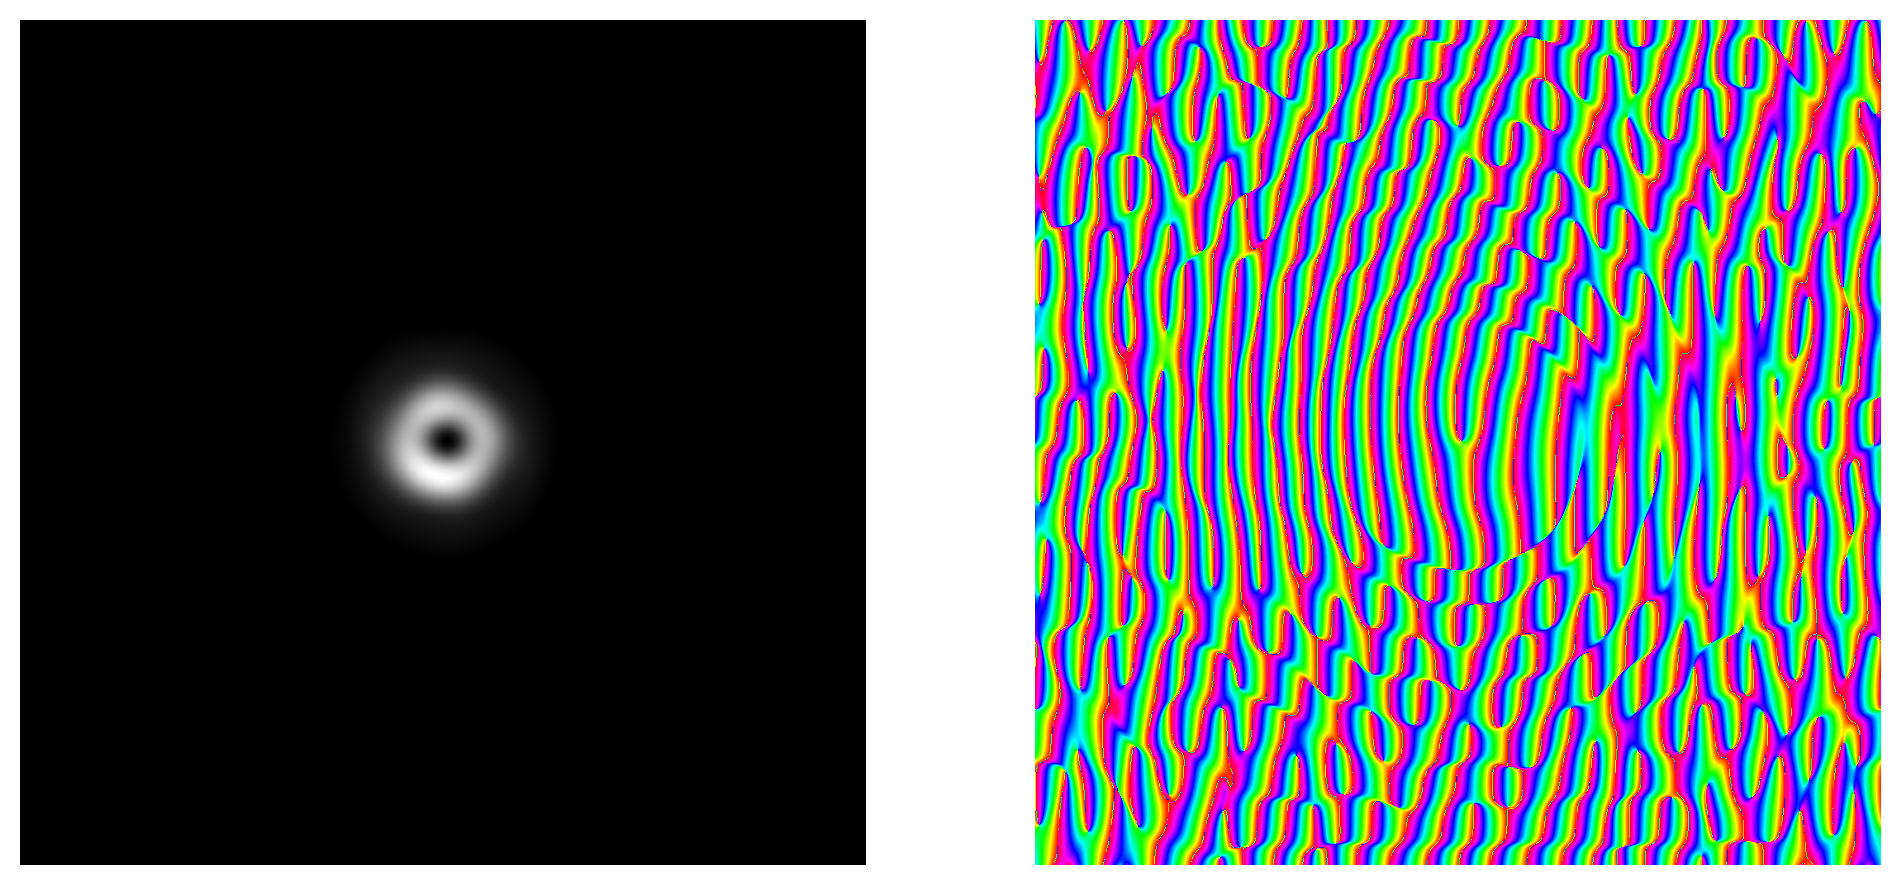

In [ ]:
KK2=propFF(U1,2*maxx,1,2)
#otInt(KK2[0])
plt.figure(figsize=(12,12),dpi=200)
plt.subplot(121)
plt.imshow(abs(KK2[0])**2,cmap="gist_gray")
plt.axis('off')
plt.subplot(122)
plt.imshow(np.angle(KK2[0]),cmap='hsv')
plt.axis('off')
plt.show()

In [ ]:
# Beam profile

k=2*np.pi  # [m^-1] wavenumber         # [mm] beam waist
maxx=4       # [units of w0] Half length of the numerical window
N=1024        # [Number of points per dimension]
                # For fast results, consider using an square matrix and N to be a power of 2
# Space definition
X=np.linspace(-maxx,maxx,N);
Y=-np.linspace(-maxx,maxx,N);

h=np.abs(X[1]-X[2]);
xx,yy=np.meshgrid(X,Y);
r, phi= cart2pol(xx,yy)

A=Gaussian(X,Y,0.5)
LA = 0.05

# Hologram calculation
Hol1=Hologram(A,h,h,LA)


# Going to the focal plane of a lens
KK=propFF(Hol1,2*maxx,1,2)

plt.figure(figsize=(20,20),dpi=100)
plt.imshow(np.abs(KK[0])**2)
plt.title('Close up to the diffraction orders',fontsize=25)
plt.text(np.round(N/2-0.01*N),np.round(N/2-0.02*N),'Zeroth order',color='w',fontsize=20)
plt.text(np.round(N/2+0.06*N),np.round(N/2-0.02*N),'First order',color='w',fontsize=20)
plt.xlim([np.round(N/2-0.03*N),np.round(N/2+0.4*N)])
plt.ylim([np.round(N/2-0.03*N),np.round(N/2+0.03*N)])
#plt.ylim([230,280])
plt.axis('off')
plt.show()